# Singapore Pools Winning Statistics Analysis

In [11]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import bs4
from bs4 import BeautifulSoup

from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
### Configs / Constants ###
FD_DRAW_LIST_URL = 'http://www.singaporepools.com.sg/DataFileArchive/Lottery/Output/fourd_result_draw_list_en.html'
FD_RESULT_URL = 'http://www.singaporepools.com.sg/en/product/Pages/4d_results.aspx?sppl='
TOTO_DRAW_LIST_URL = 'http://www.singaporepools.com.sg/DataFileArchive/Lottery/Output/toto_result_draw_list_en.html'
TOTO_RESULT_URL = 'http://www.singaporepools.com.sg/en/product/sr/Pages/toto_results.aspx?sppl='

PARSER_NAME = 'html.parser'

SPPL_ATTR = 'querystring'
SPPL_TAG = 'option'

DT_FORMAT = '%d %b %Y'
DRAW_DATE_CLASS = 'drawDate'

FD_FIRST_PRIZE_CLASS = 'tdFirstPrize'
FD_SECOND_PRIZE_CLASS = 'tdSecondPrize'
FD_THIRD_PRIZE_CLASS = 'tdThirdPrize'
FD_STARTER_PRIZE_CLASS = 'tbodyStarterPrizes'
FD_CONSOLATION_PRIZE_CLASS = 'tbodyConsolationPrizes'

FD_STARTER_PRIZE_CSS_SEL = ' '.join(['.' + FD_STARTER_PRIZE_CLASS, 'td'])
FD_CONSOLAION_PRIZE_CSS_SEL = ' '.join(['.' + FD_CONSOLATION_PRIZE_CLASS, 'td'])

FD_LAST_N_DRAWS = 10

TOTO_OUTLETS = 'divWinningOutlets'

LOSE = 'Lose'

# Part I: 4D Analysis

In [6]:
### Get 4D Draw List ###
fd_draw_list_page = requests.get(FD_DRAW_LIST_URL)
fd_draw_list_soup = BeautifulSoup(fd_draw_list_page.content, PARSER_NAME)
fd_sppl_ids = [draw.get(SPPL_ATTR).rpartition('=')[2] for draw in fd_draw_list_soup.find_all(SPPL_TAG)]


### Iterate through 4D Draw List to Consolidate 4D Results ###
fd_result_list = []
i = 0
for fd_sppl_id in fd_sppl_ids:
    i += 1
    if i > FD_LAST_N_DRAWS:
        break

    fd_result_page = requests.get(FD_RESULT_URL + fd_sppl_id)
    fd_result_soup = BeautifulSoup(fd_result_page.content, PARSER_NAME)
    
    fd_result_dt = datetime.strptime(fd_result_soup.find_all(class_=DRAW_DATE_CLASS)[0].get_text().rpartition(', ')[2], DT_FORMAT)
    fd_result_first_prize = fd_result_soup.find_all(class_=FD_FIRST_PRIZE_CLASS)[0].get_text()
    fd_result_second_prize = fd_result_soup.find_all(class_=FD_SECOND_PRIZE_CLASS)[0].get_text()
    fd_result_third_prize = fd_result_soup.find_all(class_=FD_THIRD_PRIZE_CLASS)[0].get_text()
    fd_result_starter_prize_list = [fd_prize_num.get_text() for fd_prize_num in fd_result_soup.select(FD_STARTER_PRIZE_CSS_SEL)]
    fd_result_consolation_prize_list = [fd_prize_num.get_text() for fd_prize_num in fd_result_soup.select(FD_CONSOLAION_PRIZE_CSS_SEL)]
    fd_result_round_prize_list = fd_result_consolation_prize_list \
                        + fd_result_starter_prize_list \
                        + [fd_result_first_prize, fd_result_second_prize, fd_result_third_prize]
    
    fd_result_list.append([fd_result_dt, fd_result_first_prize, FD_FIRST_PRIZE_CLASS])
    fd_result_list.append([fd_result_dt, fd_result_second_prize, FD_SECOND_PRIZE_CLASS])
    fd_result_list.append([fd_result_dt, fd_result_third_prize, FD_THIRD_PRIZE_CLASS])
    for fd_prize_num in fd_result_starter_prize_list:
        fd_result_list.append([fd_result_dt, fd_prize_num, FD_STARTER_PRIZE_CLASS])
    for fd_prize_num in fd_result_consolation_prize_list:
        fd_result_list.append([fd_result_dt, fd_prize_num, FD_CONSOLATION_PRIZE_CLASS])
        
    fd_result_round_lose_numbers = [[fd_result_dt, str(num).zfill(4), LOSE] for num in range(10000) if str(num).zfill(4) not in fd_result_round_prize_list]
    for fd_lose_set in fd_result_round_lose_numbers:
        fd_result_list.append(fd_lose_set)
        

### Present Findings in pd DataFrame ###
fd_result_df = pd.DataFrame(np.array(fd_result_list), columns=['Date', 'Prize Number', 'Prize Type'])
fd_result_df.set_index('Date', inplace=True)
fd_result_df['Win'] = (fd_result_df['Prize Type'] != LOSE).replace(True, 1)

### Get individual digits of winning number + some feature engineering ###
fd_position_set = ('First', 'Second', 'Third', 'Fourth')
fd_number_set = ('Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine')

#### Feature for numbers in each digit position ####
for i, position in enumerate(fd_position_set):
    column_name = position + ' Digit'
    fd_result_df[column_name] = fd_result_df['Prize Number'].str[i]

#### One hot features for each position + number combination ####
for i, position in enumerate(fd_position_set):
    for j, number in enumerate(fd_number_set):
        column_name = position + ' Digit ' + number
        fd_result_df[column_name] = (fd_result_df['Prize Number'].str[i] == str(j)).replace(True, 1)

#### One hot features for number ####
for k, number in enumerate(fd_number_set):
    column_name = 'Has ' + number
    fd_result_df[column_name] = fd_result_df['Prize Number'].str.contains(str(k)).replace(True, 1)


In [27]:
### Data Analysis for visualization ###
prize_num_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby(['Prize Number']).count().iloc[:, 0].sort_values(ascending=False)
first_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('First Digit').count().iloc[:, 0]
second_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('Second Digit').count().iloc[:, 0]
third_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('Third Digit').count().iloc[:, 0]
fourth_digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].groupby('Fourth Digit').count().iloc[:, 0]
digit_freq = fd_result_df[fd_result_df['Prize Type'] != LOSE].iloc[:, -10:].sum()

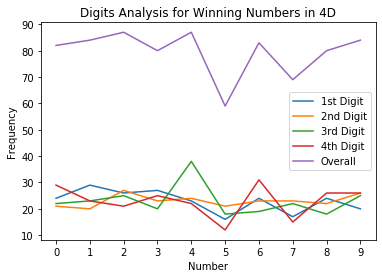

In [80]:
### Analysis of Digits ###
plt.plot(first_digit_freq, label='1st Digit')
plt.plot(second_digit_freq, label='2nd Digit')
plt.plot(third_digit_freq, label='3rd Digit')
plt.plot(fourth_digit_freq, label='4th Digit')
plt.plot([i for i in range(10)], digit_freq, label='Overall')
plt.title('Digits Analysis for Winning Numbers in 4D')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Some findings from the above plot:
* Number "1" occurs quite frequently as the 1st digit
* Occurences of all numbers in the 2nd digit appears to be quite balanced
* Number "4" occurs quite frequently as the 3rd digit
* Number "6" occurs quite frequently as the 4th digit
* Number "5" occurs the least frequently

## Attempt to use Light GBM as an estimator
* Use of GridSearch to optimize estimator's parameters

In [24]:
### Read Data ###
X_train = fd_result_df.iloc[:, 7:]
Y_train = fd_result_df.iloc[:, 2]

### GridSearchCV on LightGBM Params ###
lgbmc = LGBMClassifier()
param_grid = [
    {
        'n_jobs': [2],
        'n_estimators': [3, 5, 10],
        'max_depth': [2],
        'reg_lambda': [0]
    }
]

start_time = datetime.now()
gscv = GridSearchCV(estimator=lgbmc, n_jobs=2, cv=5, param_grid=param_grid)
gscv.fit(X_train, Y_train)
end_time = datetime.now()
print('Time taken for Grid Search: ', end_time - start_time)
print('Best score for lgbmc: ', gscv.best_score_)
print('Best params for lgbmc: ', gscv.best_params_)

### Set best estimator from GridSearchCV ###
lgbmc = gscv.best_estimator_

Time taken for Grid Search:  0:00:05.718911
Best score for lgbmc:  0.9977
Best params for lgbmc:  {'max_depth': 2, 'n_estimators': 3, 'n_jobs': 2, 'reg_lambda': 0}


In [66]:
### Preparing Test Data ###
X_test = pd.DataFrame(np.array([str(num).zfill(4) for num in range(10000)]), columns=['Prize Number'])

#### One hot features for each position + number combination ####
for i, position in enumerate(fd_position_set):
    for j, number in enumerate(fd_number_set):
        column_name = position + ' Digit ' + number
        X_test[column_name] = (X_test['Prize Number'].str[i] == str(j)).replace(True, 1)

#### One hot features for number ####
for k, number in enumerate(fd_number_set):
    column_name = 'Has ' + number
    X_test[column_name] = X_test['Prize Number'].str.contains(str(k)).replace(True, 1)

    
### Predicting 'Best' 4D Number ###
Y_pred = pd.DataFrame(lgbmc.predict_proba(X_test.iloc[:, 1:]), columns=['Lose', 'Win'])
XY_pred_join = pd.concat([X_test.loc[:, 'Prize Number'], Y_pred.loc[:, 'Win']], axis=1)
print('Predicting top 10 4D winning numbers: ')
XY_pred_join.sort_values('Win', ascending=False).head(10).style

Predicting top 10 4D winning numbers: 


,Prize Number,Win
1243,1243,0.00414359
1743,1743,0.00414359
1643,1643,0.00414359
1343,1343,0.00414359
1043,1043,0.00414359
1443,1443,0.00414359
1843,1843,0.00414359
1943,1943,0.00414359
1143,1143,0.00414359
1543,1543,0.00373925


## ^ "Prophet"'s prediction (take it with a pinch of salt, only 0.4% confident :P)

In [68]:
### Get Toto Draw List ###
toto_draw_list_page = requests.get(TOTO_DRAW_LIST_URL)
toto_draw_list_soup = BeautifulSoup(toto_draw_list_page.content, PARSER_NAME)
toto_sppl_ids = [draw.get(SPPL_ATTR).rpartition('=')[2] for draw in toto_draw_list_soup.find_all(SPPL_TAG)]


In [69]:
for i in range(0, 5):
    toto_result_page = requests.get(TOTO_RESULT_URL + toto_sppl_ids[i])
    toto_result_soup = BeautifulSoup(toto_result_page.content, PARSER_NAME)
    toto_result_dt = datetime.strptime(toto_result_soup.find_all(class_=DRAW_DATE_CLASS)[0].get_text().rpartition(', ')[2], DT_FORMAT)
    winning_outlets = toto_result_soup.select('.divWinningOutlets ul')
    if len(winning_outlets) != 0:
        pass